# HACK4LEM

Golem IV - Invisible Banking

### Import TensorFlow and other libraries

In [164]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tempfile
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from pdf2image import convert_from_path

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [127]:
data_dir = pathlib.Path('.')
pdfs = list(data_dir.glob('pdfs/*.pdf'))

for n, pdf in enumerate(pdfs):
    pages = convert_from_path(pdf, 500)
    for i, page in enumerate(pages):
        if (i == 0):
            if (len(pages) == 1):
                pname = 'pdf' + str(n) + '.png'
                page.save(pname, 'PNG')
            else :
                pname = 'tmp/__' + str(i) + '.png'
                page.save(pname, 'PNG')
        if (i == 1):
            im1 = Image.open('tmp/__0.png')
            im2 = Image.open('tmp/__1.png')
            if (len(pages) == 2):
                get_concat_v(im1, im2).save('pdf' + str(n) + '.png', 'PNG')
            else :
                get_concat_v(im1, im2).save('tmp/__0_1.png', 'PNG')
    
        if (i == 2):
            im3 = Image.open('tmp/__0_1.png')
            im4 = Image.open('tmp/__2.png')
            if (len(pages) == 3):
                get_concat_v(im3, im4).save('pdf' + str(n) + '.png', 'PNG')
                

SIZE = 512

pdfs = list(data_dir.glob('*.png'))
                
for pdf in pdfs:
    im = Image.open(pdf)
    if (im.width > SIZE or im.height > SIZE):
        im.thumbnail((SIZE, SIZE))
        im.save(pdf, 'PNG')

# Explore the dataset

In [128]:
data_dir = pathlib.Path('.')

In [165]:
image_count = len(list(data_dir.glob('out/*/*.png')))
print(image_count)

99


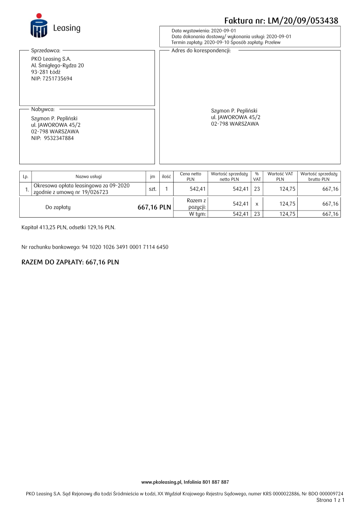

In [166]:
pko_invoices = list(data_dir.glob('out/pko/*.png'))
PIL.Image.open(str(pko_invoices[0]))

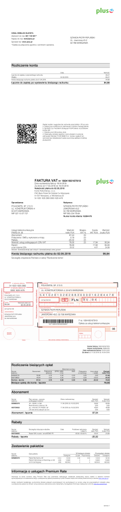

In [168]:
plus_invoices = list(data_dir.glob('out/plus/*.png'))
PIL.Image.open(str(plus_invoices[0]))

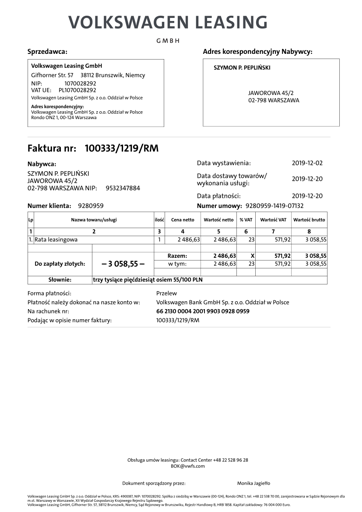

In [169]:
plus_invoices = list(data_dir.glob('out/vw/*.png'))
PIL.Image.open(str(plus_invoices[0]))

### Load using keras.preprocessing

Create a dataset

In [170]:
batch_size = 32
img_height = 224
img_width  = 224

data_dir = pathlib.Path('out')

In [171]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size
)

Found 99 files belonging to 3 classes.
Using 80 files for training.


In [172]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size
)

Found 99 files belonging to 3 classes.
Using 19 files for validation.


In [173]:
class_names = train_ds.class_names
print(class_names)

['pko', 'plus', 'vw']


### Visualize the data

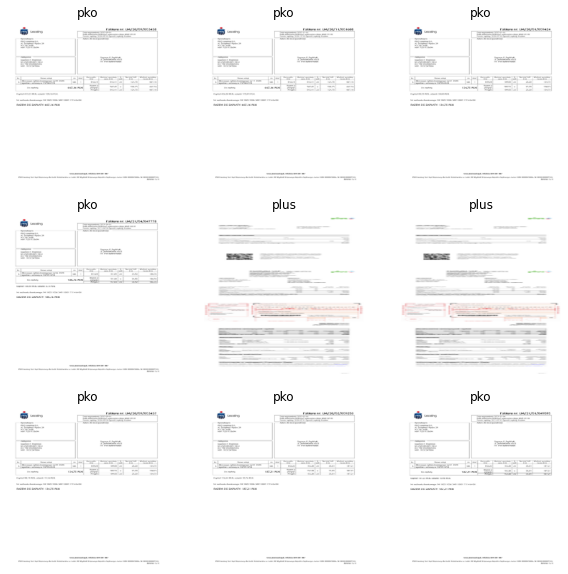

In [174]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [175]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Configure the dataset for performance

In [176]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [177]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [178]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Create the model

In [201]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [202]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [192]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)       

### Train the model

In [203]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
3/3 [==============================] - 2s 435ms/step - loss: 3.8064 - accuracy: 0.3375 - val_loss: 5.5794 - val_accuracy: 0.2105
Epoch 2/40
3/3 [==============================] - 1s 399ms/step - loss: 2.3667 - accuracy: 0.3625 - val_loss: 1.0580 - val_accuracy: 0.3158
Epoch 3/40
3/3 [==============================] - 1s 452ms/step - loss: 1.1412 - accuracy: 0.3250 - val_loss: 1.2802 - val_accuracy: 0.2105
Epoch 4/40
3/3 [==============================] - 1s 393ms/step - loss: 1.0373 - accuracy: 0.4750 - val_loss: 1.1266 - val_accuracy: 0.2105
Epoch 5/40
3/3 [==============================] - 1s 449ms/step - loss: 0.9809 - accuracy: 0.4750 - val_loss: 1.0493 - val_accuracy: 0.2105
Epoch 6/40
3/3 [==============================] - 1s 376ms/step - loss: 0.9252 - accuracy: 0.4750 - val_loss: 1.0508 - val_accuracy: 0.2105
Epoch 7/40
3/3 [==============================] - 1s 373ms/step - loss: 0.8276 - accuracy: 0.6500 - val_loss: 0.9598 - val_accuracy: 0.2105
Epoch 8/40
3/3 [====

### Visualize training results

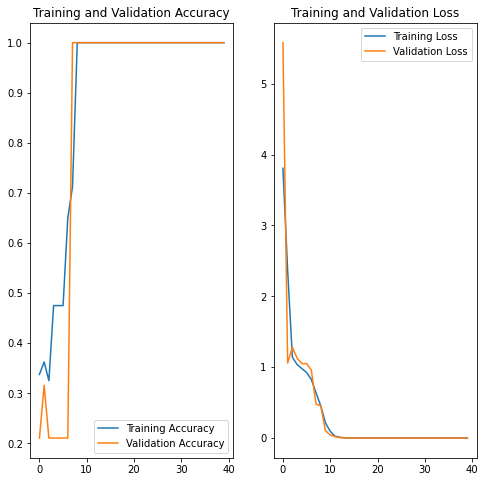

In [204]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data

In [205]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 76ms/step - loss: 4.5613e-06 - accuracy: 1.0000
Test accuracy : 1.0


This image most likely belongs to pko with a 100.00 percent confidence.


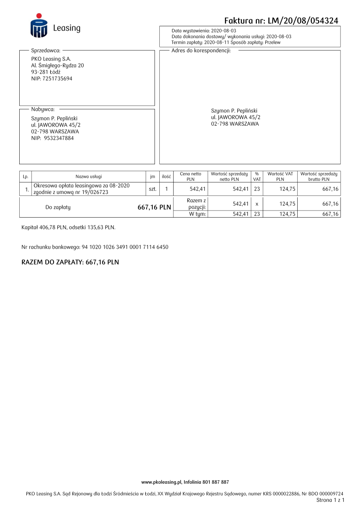

In [206]:
test_image_path = pathlib.Path('test_pko_pdf42.png')
#test_image_path = pathlib.Path('test_plus_pdf38.png')
#test_image_path = pathlib.Path('test_vw_pdf23.png')

img = keras.preprocessing.image.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This invoice belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

PIL.Image.open(str(test_image_path))

In [207]:
!mkdir -p saved_model
model.save('saved_model/lem_model.h5')

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('saved_model/lem_model.h5')
#new_model.summary()

This invoice most likely belongs to plus with a 100.00 percent confidence.


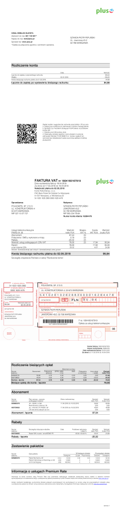

In [208]:
test_image_path = pathlib.Path('test_plus_pdf38.png')

img = keras.preprocessing.image.load_img(
    test_image_path, target_size = (img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This invoice belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

PIL.Image.open(str(test_image_path))